In [1]:
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import random
import numpy as np
from scipy.interpolate import make_interp_spline

In [2]:
def get_raw_data(personalised=False):
    """
    Read .json files and append data to a dict with a key of sessions
    """
    data = {'sessions': []}
    if personalised:
        datadir = "./personalised_data/"
    else:
        datadir = "./data/"

    files = [fname for fname in os.listdir(datadir) if fname.endswith('.json')]
    
    for file in files:
        with open(f"{datadir}{file}", "r") as f:
            js = json.load(f)
            data['sessions'].extend(js['sessions'])
    
    return data

In [3]:
def what_commands(fname):
    """
    Return which commands were prompted in a given file (session)
    """
    with open (fname, "r") as f:
        js = json.load(f)
        commands = [entry['command'] for entry in js['sessions']]
    return commands

In [4]:
def organize_by_command(data):
    """
    Return a dict where key->command, value->list of list of keystrokes
    """
    commands = defaultdict(list)
    for session in data['sessions']:
        command = session['command']
        keystrokes = session['keystrokes']
        if len(keystrokes) == 0 or len(keystrokes) < len(command):
               continue
        commands[command].append(keystrokes)
    return commands

In [5]:
def zero_first(data):
    """
    Set latency of the first keystroke to zero.
    """
    for cmd in data.keys():
        for session in data[cmd]:
            session[0]['latency'] = 0
    return data

In [6]:
def get_prepared_data(personalised=False):
    """
    Return ordered, zeroed, data dictionary.
    """
    data = get_raw_data(personalised)
    organised = organize_by_command(data)
    zeroed = zero_first(organised)
    return zeroed

In [7]:
def combine_common_tokens(dataset):
    """
    Certain keywords are reused in the dataset. We can combine them for increased coverage.
    i.e. sudo, install, apt, service, etc.
    """
    # We could make this selection automatic via a hashmap, but the idea is that
    # only certain keywords play a big enough role- especially for sudo, which will be an optional
    # prefix for commands to be considered.
    # If we went for all words, then we might as well draw the line at keypair latencies, which is not ideal.
    common_tokens = set(["sudo", "install", "service", "pacman", "systemctl"])
    aggregated_data = defaultdict(list)

    for command, sessions in dataset.items():
        splices = command.split()
        indices = [0]
        
        # Accumulate indices positions
        for i in range(1, len(splices)):
            indices.append(indices[-1] + len(splices[i-1]) + 1)  # Account for spaces

        for i, word in enumerate(splices):
            if word in common_tokens:
                start_idx = indices[i]
                end_idx = start_idx + len(word)  # Not including the space after the word

                # Extract the keystrokes corresponding to the word
                keystrokes = [session[start_idx:end_idx] for session in sessions]
                
                # Optionally nullify the first latency in each session to normalize start time
                for keystroke in keystrokes:
                    if keystroke:  # Ensure it's not an empty list
                        keystroke[0]['latency'] = 0

                aggregated_data[word].extend(keystrokes)

        # Add the full command data
        aggregated_data[command].extend(sessions)

    return aggregated_data

In [8]:
def handle_backspaces(keystroke_sequences):
    for command in keystroke_sequences.keys():
        for sequence in keystroke_sequences[command]:
            i = 0
            while i < len(sequence)-1:
                if sequence[i]['key'] == 'Backspace':
                    curr = sequence[i]
                    prev = sequence[i-1]
                    if i != 0:
                        sequence.remove(prev)
                        sequence.remove(curr)
                        i -= 1
                        continue
                    else:
                        sequence.remove(curr)
                        sequence[i+1]['latency'] = 0
                        continue
                i += 1
    return keystroke_sequences

In [9]:
cmds = combine_common_tokens(handle_backspaces(get_prepared_data(False)))

In [10]:
# Commands with most sessions in the dataset
sorted(cmds, key=lambda x: len(cmds[x]), reverse=True)

['install',
 'sudo',
 'pacman',
 '-tlpn',
 '--help',
 '-al',
 '--version',
 'service',
 'apt-get update',
 '-v',
 '--file',
 'netstat -tuln',
 'ifconfig',
 'sort file',
 'ufw enable',
 'dist-upgrade',
 'sudo pacman -S package',
 'systemctl',
 'systemctl status service',
 'iptables -L',
 'umount /mnt',
 'pacman -Syu',
 'sudo apt update',
 'ip addr',
 'wget https://example.com',
 'sudo apt-get install package',
 "awk '/pattern/ {action}' file",
 "sed 's/find/replace/' file",
 'findmnt',
 'dnf install package',
 'dd if=/dev/zero of=file bs=1M count=10',
 'tar -czvf archive.tar.gz directory',
 'gzip file',
 'free -m',
 'yum install package',
 'zip archive.zip file',
 'python3 script.py',
 'mkdir ../log',
 'apt install -y',
 'uniq file',
 'df -hT',
 'kill pid',
 'dpkg -i package.deb',
 'ssh user@host',
 'whoami',
 'top',
 'ping host',
 'pip3 install package',
 'cp id_rsa file2',
 'chmod +x file',
 'mv * /tmp',
 'less file',
 'head /etc/passwd',
 'du -h directory',
 'ps -aux',
 'su - user',


In [11]:
def plot_command_latencies(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))
    
    for sequence in keystroke_sequences:
        latencies = [keystroke['latency'] for keystroke in sequence]
        plt.plot(latencies, marker='o', linestyle='-')

    plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend([f'Session {i+1}' for i in range(len(keystroke_sequences))], loc='upper right')
    plt.grid(True)
    plt.show()

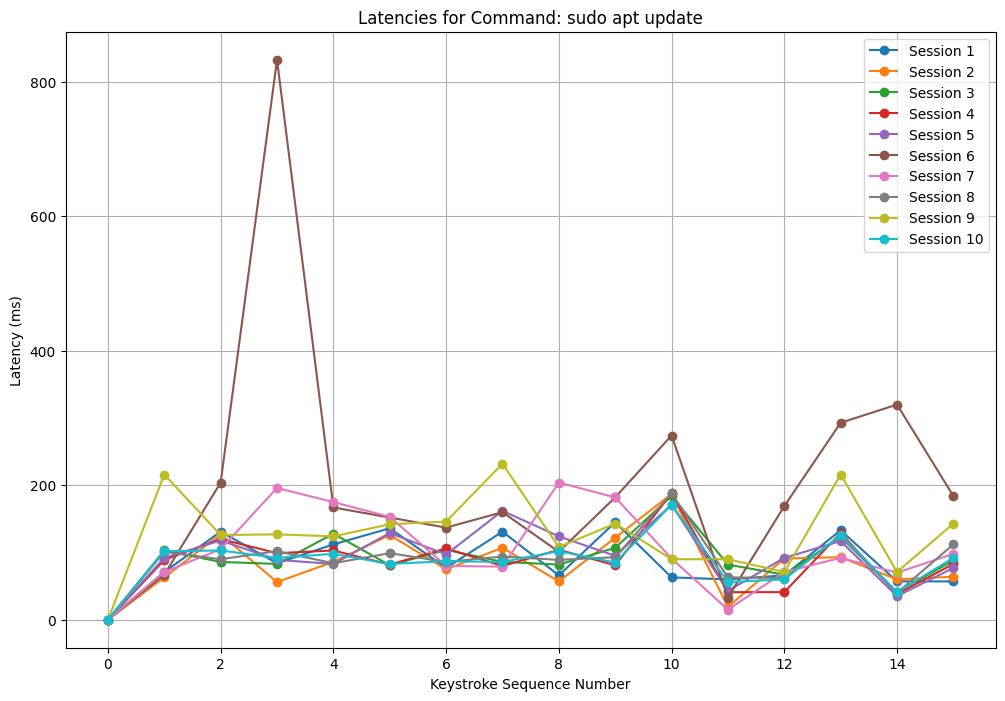

In [12]:
command = 'sudo apt update'
plot_command_latencies(cmds[command], command)

In [13]:
cmds['ifconfig'][2]

[{'key': 'i', 'latency': 0},
 {'key': 'f', 'latency': 85},
 {'key': 'c', 'latency': 145},
 {'key': 'o', 'latency': 21},
 {'key': 'n', 'latency': 149},
 {'key': 'f', 'latency': 58},
 {'key': 'i', 'latency': 82},
 {'key': 'g', 'latency': 148},
 {'key': 'Return', 'latency': 41}]

In [14]:
cmds = handle_backspaces(cmds)

In [15]:
def plot_command_latencies(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(keystroke_sequences):
        normal_keys_x = []
        normal_keys_y = []
        backspace_keys_x = []
        backspace_keys_y = []
        
        for keystroke_idx, keystroke in enumerate(sequence):
            if keystroke['key'] == 'Backspace':
                backspace_keys_x.append(keystroke_idx)
                backspace_keys_y.append(keystroke['latency'])
            normal_keys_x.append(keystroke_idx)
            normal_keys_y.append(keystroke['latency'])
                
        # Plot normal keystrokes
        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session {sequence_idx + 1} Keystrokes', zorder=1)
        # Plot Backspace keystrokes
        plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session {sequence_idx + 1} Backspaces', zorder=2)

    plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

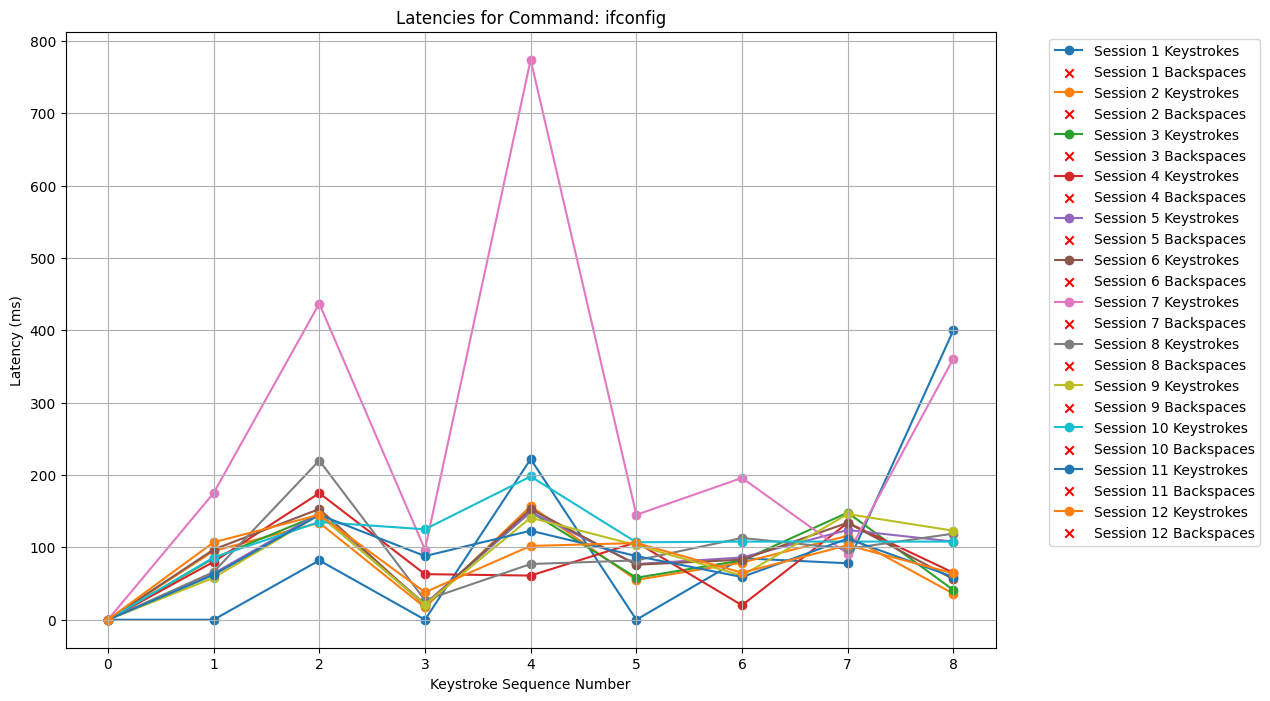

In [17]:
command = "ifconfig"
plot_command_latencies(cmds[command], command)

In [18]:
def plot_command_distribution(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))

    total_latencies = [0] * (len(command) + 1)
    count_per_position = [0] * (len(command) + 1)

    # Plot each keystroke sequence
    for sequence in keystroke_sequences:
        normal_keys_x = []
        normal_keys_y = []
        
        for idx, keystroke in enumerate(sequence):
            normal_keys_x.append(idx)
            normal_keys_y.append(keystroke['latency'])
            if idx < len(total_latencies):
                total_latencies[idx] += keystroke['latency']
                count_per_position[idx] += 1

        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', color='blue', alpha=0.3, zorder=1)
    
    # Calculate mean latencies
    means = [total_latencies[i] / count_per_position[i] if count_per_position[i] else 0 for i in range(len(command)+1)]
    x_new = np.linspace(0, len(command), 300)  # 300 represents number of points to make between T.min and T.max

    # Smoothing the line
    spl = make_interp_spline(range(len(command)+1), means, k=3)  # BSpline object
    y_smooth = spl(x_new)

    plt.plot(x_new, y_smooth, marker='', linestyle='-', label='Mean keystroke latency', color='red', linewidth=2, zorder=2)

    plt.title(f'Mean latencies for command: "{command}"')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

In [19]:
cmds = combine_common_tokens(handle_backspaces(get_prepared_data(False)))

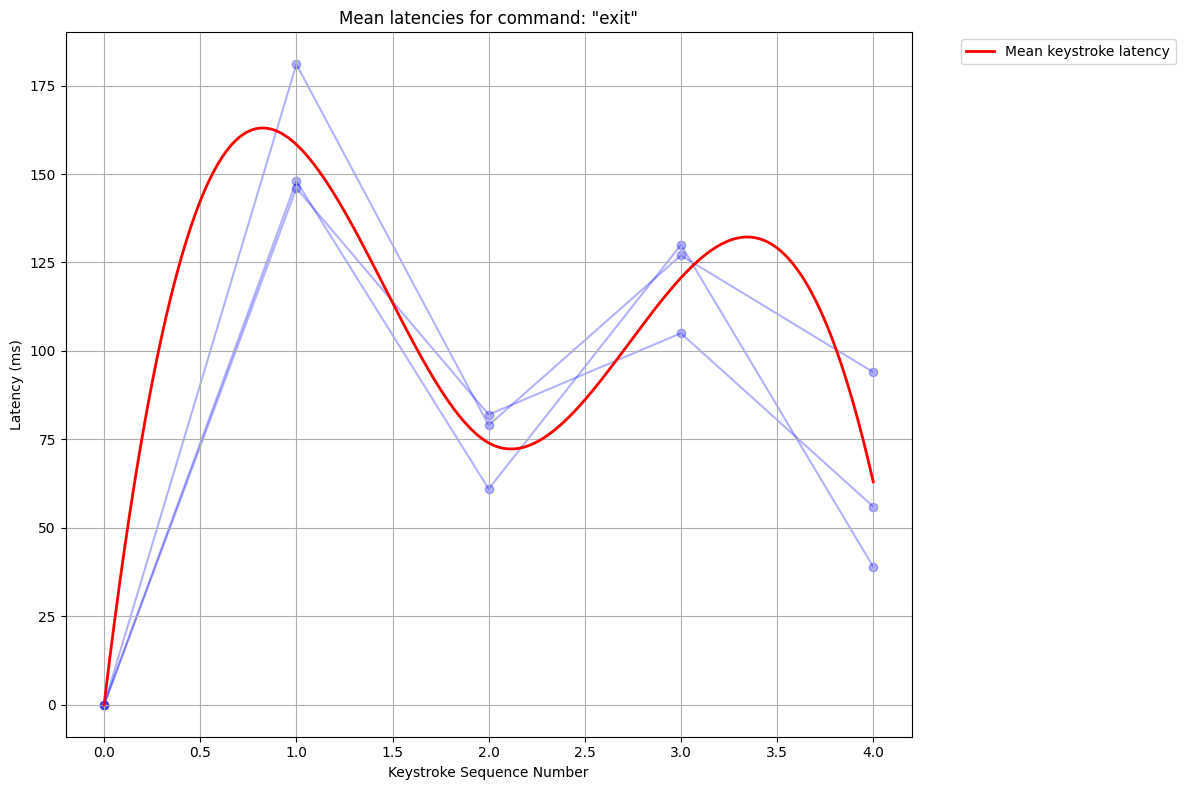

In [22]:
command = 'exit'
plot_command_distribution(cmds[command], command)

In [23]:
def load_ssh_session(path, stream=0):
    """
    Load SSHniff session (JSON) output.

    By default, assume single-session, which will have stream="0".
    """
    stream = str(stream)
    
    with open(path, "r") as f:
        data = json.loads(f.read())
    # SSHniff full output
    if 'keystroke_data' in data[stream]:
        return convert_latencies(data[stream]['keystroke_data'])
    # Only keystroke data
    return convert_latencies(data[stream])

In [24]:
def convert_latencies(ssh_data):
    """
    Convert latencies from microseconds to milliseconds. 
    """
    for sequence in ssh_data:
        for keystroke in sequence:
            keystroke['timestamp'] = keystroke['timestamp'] / 1000
    return ssh_data

In [25]:
ssh_data = load_ssh_session("./sshniff_output/keystrokes.json")

In [26]:
ssh_data[0]

[{'k_type': 'Keystroke', 'timestamp': 0.0, 'response_size': None, 'seq': 2602},
 {'k_type': 'Keystroke',
  'timestamp': 224.186,
  'response_size': None,
  'seq': 2638},
 {'k_type': 'Keystroke',
  'timestamp': 144.008,
  'response_size': None,
  'seq': 2674},
 {'k_type': 'Keystroke',
  'timestamp': 103.813,
  'response_size': None,
  'seq': 2710},
 {'k_type': 'Keystroke',
  'timestamp': 167.979,
  'response_size': None,
  'seq': 2746},
 {'k_type': 'Keystroke',
  'timestamp': 120.27,
  'response_size': None,
  'seq': 2782},
 {'k_type': 'Enter', 'timestamp': 1823.813, 'response_size': 304, 'seq': 2854}]

In [16]:
def plot_ssh_data(sequence):
    plt.figure(figsize=(12, 8))
    normal_keys_x = []
    normal_keys_y = []
    backspace_keys_x = []
    backspace_keys_y = []
    enter_keys_x = []
    enter_keys_y = []

    for keystroke_idx, keystroke in enumerate(sequence):
        if keystroke['k_type'] == 'Delete':
            backspace_keys_x.append(keystroke_idx)
            backspace_keys_y.append(keystroke['timestamp'])
        elif keystroke['k_type'] == 'Enter':
            enter_keys_x.append(keystroke_idx)
            enter_keys_y.append(keystroke['timestamp'])
        normal_keys_x.append(keystroke_idx)
        normal_keys_y.append(keystroke['timestamp'])
                
    # Plot normal keystrokes
    plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session 1 Keystrokes', zorder=1)
    # Plot Backspace keystrokes
    plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session 1 Backspaces', zorder=2)
    plt.scatter(enter_keys_x, enter_keys_y, color='green', marker='x', label=f'Session 1 Return', zorder=3)

    plt.title(f'Latencies for SSH sequence')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

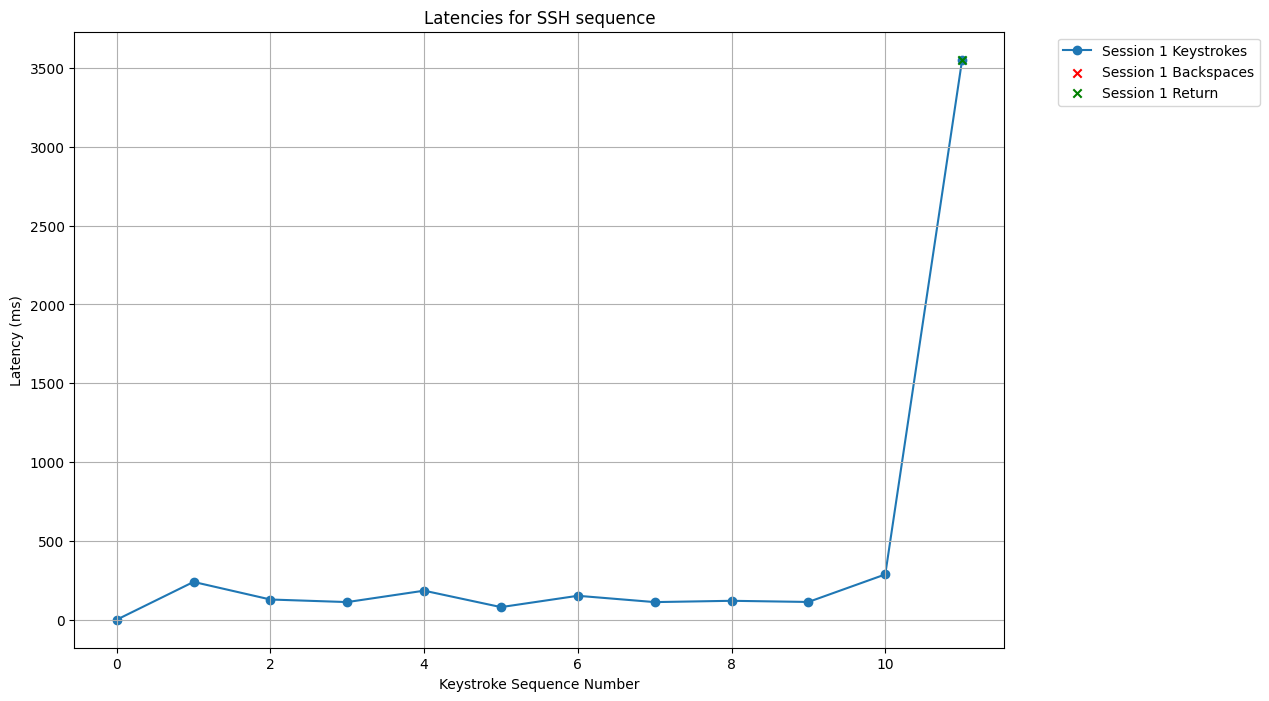

In [28]:
plot_ssh_data(ssh_data[4])

In [112]:
def plot_ssh_data(ssh_sessions):
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(ssh_sessions):
        keystroke_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Keystroke']  # Convert to milliseconds
        enter_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Enter']
        enter_sizes = [event['response_size'] for event in sequence if event['k_type'] == 'Enter']
        
        # Plotting keystrokes
        plt.plot(keystroke_times, [sequence_idx + 1] * len(keystroke_times), 'bo', label='Keystrokes' if sequence_idx == 0 else "")
        
        # Plotting Enter presses
        for enter_time, size in zip(enter_times, enter_sizes):
            plt.plot(enter_time, sequence_idx + 1, 'rx', label='Enter Press' if sequence_idx == 0 else "")
            plt.text(enter_time, sequence_idx + 1, f' {size}B', verticalalignment='bottom')

    plt.yticks(range(1, len(ssh_sessions) + 1), [f'Sequence {i+1}' for i in range(len(ssh_sessions))])
    plt.title('SSH Packet Timestamps and Enter Presses')
    plt.xlabel('Time (ms)')
    plt.ylabel('Sequence Number')
    plt.legend()
    plt.grid(True)
    plt.show()

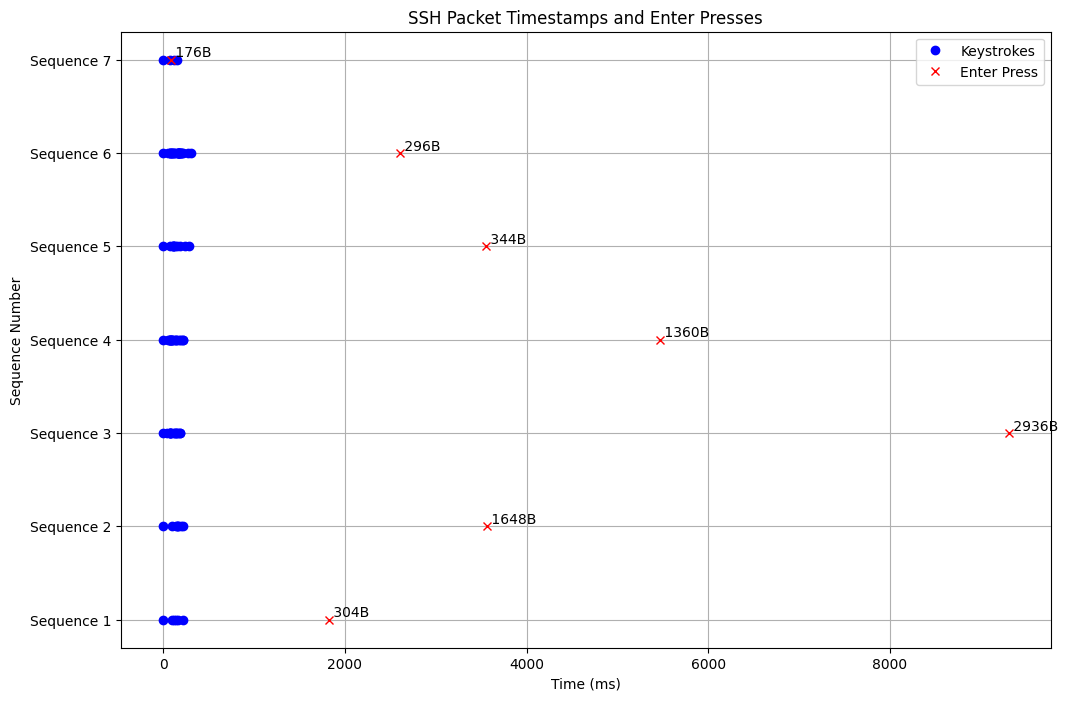

In [375]:
plot_ssh_data(ssh_data)

In [335]:
## Dynamic Time Warping (DTW)

In [17]:
from dtaidistance import dtw
import numpy as np

In [377]:
ssh_data = convert_latencies(load_ssh_data("./sshniff_output/keystrokes.json"))
cmds = get_prepared_data(True)
cmds = handle_backspaces(cmds)
cmds = combine_common_tokens(cmds)

In [378]:
# Remove RETURN from intercept?
for sequence in ssh_data:
    sequence.pop()

In [71]:
# Expects get_mean_latencies('id', cmds['id'])
# Ignores RET, unless command has an extra character at the end.
def get_mean_latencies(command, command_dataset):
    means = [0 for i in range(len(command))]
    for letter_index, letter in enumerate(command):
        for sequence in command_dataset:
            means[letter_index] += sequence[letter_index]['latency']
    means = [i / len(command_dataset) for i in means]
    return np.array(means)

In [12]:
command = "iptables -L"
unlabeled_latencies = np.array([keystroke['timestamp'] for keystroke in ssh_data[4]])
cmd_mean_latencies = get_mean_latencies(command, cmds[command]) 

NameError: name 'ssh_data' is not defined

In [381]:
[keystroke['timestamp'] for keystroke in ssh_data[2]]

[0.0,
 79.973,
 151.947,
 167.776,
 184.25,
 144.38,
 87.696,
 128.233,
 79.999,
 104.02,
 191.915,
 79.751,
 79.902,
 135.933,
 48.148]

In [382]:
cmd_mean_latencies

array([  0.        , 172.18181818,  62.45454545,  72.72727273,
       154.36363636,  80.18181818, 139.09090909,  87.18181818,
       106.81818182,  87.18181818, 232.45454545])

In [383]:
unlabeled_norm = unlabeled_latencies / np.max(unlabeled_latencies)
known_norm = cmd_mean_latencies / np.max(cmd_mean_latencies)
distance = dtw.distance(unlabeled_norm, known_norm)
print("DTW Distance:", distance)

DTW Distance: 0.24139264595530577


In [72]:
def eliminate_candidates(intercept_length, command_dataset):
    """
    Reduces the scope of possible commands.

    Using the intercepted command's length, we can exclude commands with 
    a minimum length longer than the intercept. 
        i.e.: A five-letter intercept (XXXXX) cannot be ifconfig, no matter
        how well the signature might match.
    """
    candidates = {}
    for command in command_dataset.keys():
        splices = command.split(' ')
#        if splices[0] == 'sudo':
#            if len(splices[1]) + 5 > intercept_length:
#                # Ignore command if itself 
#                continue
        if len(splices[0]) > intercept_length:
            # Ignore command if it is longer than the intercepted length.
            # i.e., a five-letter intercept cannot be <ifconfig>, no matter how well it matches.
            continue
        else:
            candidates[command] = command_dataset[command]
    return candidates

In [73]:
def find_best_match(intercepted, command_dataset):
    """
    Creates an ordered list of the distance of all possible commands to an intercepted sequence.

    Distance is calculated using Dynamic Time Warping (DTW). 
    """
    unlabeled_latencies = np.array([keystroke['timestamp'] for keystroke in intercepted])
    unlabeled_norm = unlabeled_latencies / np.max(unlabeled_latencies)

    distances = []
    candidates = eliminate_candidates(len(intercepted), command_dataset)
    for command in candidates.keys():
        try:
            cmd_mean_latencies = get_mean_latencies(command, command_dataset[command])
        except:
            print(f"failed at {command}")
            continue
        known_norm = cmd_mean_latencies / np.max(cmd_mean_latencies)
        distance = dtw.distance(unlabeled_norm, known_norm)
        distances.append((command, distance))

    distances = sorted(distances, key=lambda x: x[1])
    return distances

In [386]:
find_best_match(ssh_data[3], cmds)

[('sudo apt upgrade ', 0.57410781494813),
 ('ping -c 1 9.9.9.9', 0.638267611745968),
 ('ifconfig', 0.7307000728774575),
 ('cat /etc/hosts', 0.7403838809952429),
 ('curl http://', 0.7795780237676415),
 ('iptables -L', 0.7817823847563101),
 ('tar --help', 0.7880689214823248),
 ('cat /etc/resolv.conf', 0.7936981502072052),
 ('systemctl', 0.8043030471932169),
 ('systemctl stop ', 0.8079253702170153),
 ('systemctl status ', 0.8267712297400878),
 ('touch ', 0.8480534614210572),
 ('cat /etc/passwd', 0.8500276724142628),
 ('iptables -S', 0.865134638281377),
 ('wget https://', 0.8664987368072451),
 ('sudo apt update', 0.8701679313553401),
 ('df -hT /', 0.8703338084395944),
 ('rm -rf /tmp/*', 0.8782204900943745),
 ('systemctl restart ', 0.892205146199822),
 ('tail /var/log/syslog', 0.9050254308315562),
 ('systemctl start ', 0.9176605670821919),
 ('mv * ../', 0.9345266490351055),
 ('uptime', 0.9997655825972209),
 ('exit', 1.0078100550645708),
 ('whoami', 1.0350429240855592),
 ('sudo su', 1.039394

In [356]:
sudo = ssh_data[2][:5]

In [357]:
find_best_match(sudo, cmds)

[('sudo', 0.3477635275587289),
 ('rm -rf /tmp/*', 0.3769109701734561),
 ('cd', 0.37794177956394887),
 ('tar --help', 0.3988128583661368),
 ('touch ', 0.43567575781429924),
 ('id', 0.4765795309550633),
 ('sudo su', 0.5266152825897691),
 ('curl http://', 0.5623426298853395),
 ('exit', 0.6313450587666717),
 ('wget https://', 0.6593016162287152),
 ('df -hT /', 0.6899212801101497),
 ('cat /etc/hosts', 0.8358267923331405),
 ('ping -c 1 9.9.9.9', 0.8565467769263311),
 ('tail /var/log/syslog', 0.9465034088496813),
 ('sudo apt upgrade ', 0.9608209146707403),
 ('sudo apt update', 0.980940692820885),
 ('mv * ../', 1.0045429304023148),
 ('cat /etc/passwd', 1.2376833046910585),
 ('cat /etc/resolv.conf', 1.2481967669622207)]

In [2]:
# HMM Stuff

In [45]:
with open("./commands.json", "r") as f:
    commands = json.load(f)

In [46]:
s_cmds = []
for category in commands['commands']:
    s_cmds.extend(category['patterns'])
s_cmds.extend(commands['commonFlags'])
s_cmds.extend(commands['commonPathStarts'])

In [47]:
s_cmds

['ls -l',
 'cd',
 'pwd',
 'touch ',
 'cp file1 file2',
 'mv file1 file2',
 'rm file',
 'mkdir directory',
 'rmdir directory',
 'cat file',
 'less file',
 'nano file',
 'vim file',
 'chmod +x file',
 'chown user:group file',
 'sudo command',
 'su - user',
 'whoami',
 'man command',
 "echo 'text'",
 'head ',
 'tail -f ',
 'exit',
 'ps -aux',
 'top',
 'htop',
 'kill pid',
 'df -h',
 'du -h directory',
 'uname -a',
 'uptime',
 'free -m',
 'vmstat',
 'iostat',
 'systemctl status service',
 'service name start',
 'ping host',
 'netstat -tuln',
 'ss -tuln',
 'curl https://example.com',
 'wget https://example.com',
 'scp file user@host:path',
 'ssh user@host',
 'iptables -L',
 'ufw enable',
 'ip addr',
 'apt-get update',
 'apt-get install package',
 'dpkg -i package.deb',
 'yum install package',
 'dnf install package',
 'pacman -Syu',
 'pacman -S package',
 "grep -i 'pattern' file",
 "awk '/pattern/ {action}' file",
 "sed 's/find/replace/' file",
 'sort file',
 'uniq file',
 'tar -czvf archive

In [48]:
char_pairs = set()

for cmd in s_cmds:
    for i in range(len(cmd) - 1):
        pair = cmd[i:i+2]
        char_pairs.add(pair)

In [49]:
char_pairs

{" '",
 ' +',
 ' -',
 ' a',
 ' b',
 ' c',
 ' d',
 ' e',
 ' f',
 ' h',
 ' i',
 ' n',
 ' o',
 ' p',
 ' s',
 ' u',
 ' {',
 "' ",
 "'/",
 "'p",
 "'s",
 "'t",
 '+x',
 '- ',
 '--',
 '-L',
 '-S',
 '-a',
 '-c',
 '-f',
 '-g',
 '-h',
 '-i',
 '-l',
 '-m',
 '-t',
 '-v',
 '..',
 './',
 '.c',
 '.d',
 '.g',
 '.p',
 '.t',
 '.z',
 '/ ',
 "/'",
 '//',
 '/d',
 '/e',
 '/f',
 '/p',
 '/r',
 '/z',
 '1 ',
 '10',
 '1M',
 '3 ',
 ':/',
 ':g',
 ':p',
 '=/',
 '=1',
 '=f',
 '@h',
 'M ',
 'S ',
 'Sy',
 'ab',
 'ac',
 'ad',
 'ag',
 'ai',
 'al',
 'am',
 'an',
 'ap',
 'ar',
 'at',
 'au',
 'aw',
 'bl',
 'bs',
 'ca',
 'cd',
 'ce',
 'ch',
 'ck',
 'cm',
 'co',
 'cp',
 'cr',
 'ct',
 'cu',
 'cz',
 'd ',
 'd/',
 'da',
 'dd',
 'de',
 'df',
 'di',
 'dn',
 'do',
 'dp',
 'dr',
 'du',
 'e ',
 'e.',
 'e/',
 'e1',
 'e2',
 'ea',
 'eb',
 'ec',
 'ed',
 'ee',
 'el',
 'em',
 'en',
 'ep',
 'er',
 'es',
 'et',
 'ev',
 'ex',
 'f ',
 'f=',
 'fi',
 'fr',
 'fw',
 'g ',
 'ge',
 'gr',
 'gz',
 'h ',
 'he',
 'hi',
 'hm',
 'ho',
 'ht',
 'i ',
 'ic',

In [50]:
len(char_pairs)

296

In [15]:
def get_minlen(command: str) -> int:
    # How do we reliably determine minimum length?
    # Split at first ' ' doesn't cover cmds like 'cp src dst' but it is a start.
    splice = command.split(" ", 1)[0]
    return len(splice)

In [16]:
def get_charpairs(command: str) -> (str, set()):
    if len(command) < 2:
        return
    first = set([command[:2]])
    rest = set()
    for i in range(1, len(command)-1):
        rest.add(command[i:i+2])
    return [first, rest]

In [17]:
# This one doesn't make much sense. Each start state can only logically produce certain following states, so it doesn't make sense to pool them by length
def make_state_objects(commands: list):
    # minlen -> (startstates, states)?
    state_objects = {}
    # (minlen, startstate, states)
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_charpairs(command)
        if not pairs:
            continue
        if minlen in state_objects:
            state_objects[minlen][0] = state_objects[minlen][0].union(pairs[0])
            state_objects[minlen][1] = state_objects[minlen][1].union(pairs[1])
        else:
            state_objects[minlen] = pairs
    return state_objects

In [18]:
def get_pairs(command: str):
    pairs = []
    for i in range(len(command) - 1):
        pair = command[i:i+2]
        pairs.append(pair)
    return pairs

In [19]:
def make_len_map(commands: list):
    # minlen -> [["if", "fc", "co", "on", "nf", "fi", "ig"], ...]
    lenmap = {}
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_pairs(command)
        if not pairs:
            continue
        if minlen in lenmap:
            lenmap[minlen].append(pairs)
        else:
            lenmap[minlen] = [pairs]
    return lenmap

In [189]:
mp = make_len_map(s_cmds)

In [193]:
mp[5]

[['to', 'ou', 'uc', 'ch', 'h '],
 ['mk',
  'kd',
  'di',
  'ir',
  'r ',
  ' d',
  'di',
  'ir',
  're',
  'ec',
  'ct',
  'to',
  'or',
  'ry'],
 ['rm',
  'md',
  'di',
  'ir',
  'r ',
  ' d',
  'di',
  'ir',
  're',
  'ec',
  'ct',
  'to',
  'or',
  'ry'],
 ['ch', 'hm', 'mo', 'od', 'd ', ' +', '+x', 'x ', ' f', 'fi', 'il', 'le'],
 ['ch',
  'ho',
  'ow',
  'wn',
  'n ',
  ' u',
  'us',
  'se',
  'er',
  'r:',
  ':g',
  'gr',
  'ro',
  'ou',
  'up',
  'p ',
  ' f',
  'fi',
  'il',
  'le'],
 ['un', 'na', 'am', 'me', 'e ', ' -', '-a'],
 ['un',
  'nz',
  'zi',
  'ip',
  'p ',
  ' a',
  'ar',
  'rc',
  'ch',
  'hi',
  'iv',
  've',
  'e.',
  '.z',
  'zi',
  'ip']]

In [1]:
## KeyRecs stuff

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv('./keyrecs_dataset/free-text.csv', index_col=0)

C:\Users\Asus\AppData\Local\Temp\ipykernel_7708\2388355099.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./keyrecs_dataset/free-text.csv', index_col=0)


In [22]:
df = df[["key1", "key2", "DD.key1.key2"]]
bad_keys = ["Shift", "Control", "Alt", "CapsLock", "MediaTrackNext", "Dead", "End", "Insert", "OS", "Meta", "AltGraph", "AudioVolumeDown", ",0.134,0.281,0.502,0.147,0.368,\np037,2,", ",0.096,0.8,0.896,0.704,0.8,\np087,1,"]
df = df[~df['key1'].isin(bad_keys) & ~df['key2'].isin(bad_keys)]
df = df[df['DD.key1.key2'] > 0]
df = df[df['DD.key1.key2'] < 3]

In [23]:
df

,key1,key2,DD.key1.key2
participant,,,
p001,e,Space,0.172
p001,Space,b,0.200
p001,b,e,0.320
p001,e,l,1.432
p001,l,i,0.280
...,...,...,...
p100,Space,s,0.114
p100,s,t,0.120
p100,t,a,0.092


In [114]:
df['keypair'] = list(zip(df['key1'], df['key2']))

In [115]:
unique_pairs = df['keypair'].dropna().unique()
u = set(tuple(pair) for pair in unique_pairs)

In [116]:
grouped = df.groupby('keypair')['DD.key1.key2'].agg(list).reset_index()

In [145]:
def plot_latency_distribution(grouped_data, char_pair1, char_pair2=None):
    """
    Plots the latency distribution for the specified character pairs.
    
    Args:
    grouped_data (DataFrame): DataFrame with character pairs and their latencies.
    char_pair1 (tuple): First character pair to plot the distribution for.
    char_pair2 (tuple, optional): Second character pair to plot the distribution for, plotted in red if provided.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Plot for first character pair
    data1 = grouped_data[grouped_data['keypair'] == char_pair1]['DD.key1.key2'].values[0]
    sns.histplot(data1, kde=True, color="blue", bins=30, label=f'Pair {char_pair1}')

    # Plot for second character pair if provided
    if char_pair2:
        data2 = grouped_data[grouped_data['keypair'] == char_pair2]['DD.key1.key2'].values[0]
        sns.histplot(data2, kde=True, color="red", bins=30, label=f'Pair {char_pair2}')

    plt.title(f'Latency Distribution for Pairs {char_pair1}' + (f' and {char_pair2}' if char_pair2 else ''))
    plt.xlabel('Latency (seconds)')
    plt.ylabel('Frequency')
    plt.legend(title='Character Pairs')
    plt.show()

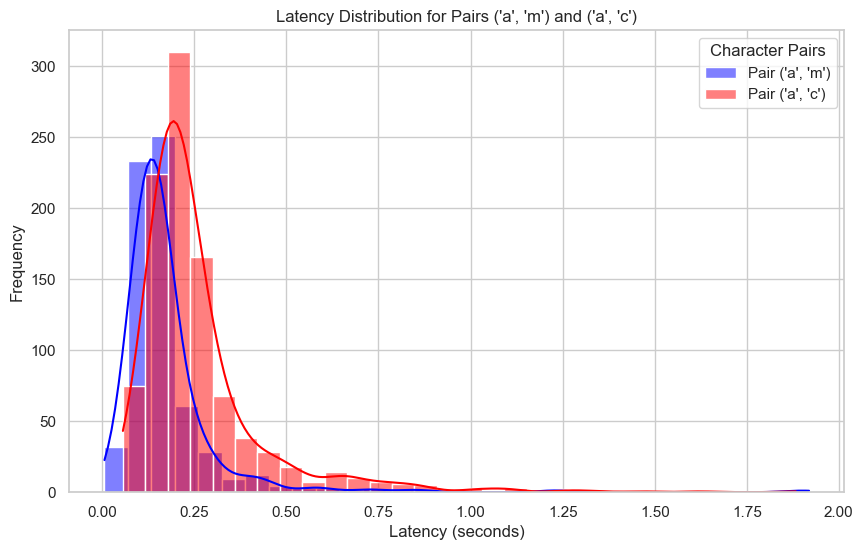

In [153]:
pair = ('a', 'm')
plot_latency_distribution(grouped, pair, ('a','c'))

In [15]:
# Trees

In [74]:
ssh_data = convert_latencies(load_ssh_session("./sshniff_output/capture_1_ssh_session.json"))
cmds = get_prepared_data(False)
cmds = handle_backspaces(cmds)
cmds = combine_common_tokens(cmds)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from tsfresh.feature_extraction import ComprehensiveFCParameters, extract_features
from tsfresh.utilities.dataframe_functions import impute
import pandas as pd

In [66]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [76]:
def extract_tsf_features(latency_sequences):
    """
    Extracts time series features from latency sequences using tsfresh.
    """
    extracted_features = extract_features(latency_sequences, column_id="id", column_sort="time", 
                                          default_fc_parameters=ComprehensiveFCParameters(), impute_function=impute)
    return extracted_features

def create_feature_matrix(commands):
    """
    Constructs a feature matrix for all commands' latency sequences.
    """
    all_features = []
    labels = []
    command_ids = {cmd: idx for idx, cmd in enumerate(commands.keys())}
    
    for command, sequences in commands.items():
        print(f"{command=}")
        for sequence in sequences:
            data = {'id': [], 'time': [], 'value': []}
            for time_point, entry in enumerate(sequence):
                data['id'].append(command_ids[command])
                data['time'].append(time_point)
                data['value'].append(entry['latency'])
            df = pd.DataFrame(data)
            features = extract_tsf_features(df)
            all_features.append(features)
            labels.append(command_ids[command])
    
    return pd.concat(all_features), np.array(labels)

In [136]:
cmds.keys()

dict_keys(['pwd', 'sudo', 'sudo command', 'cat file', 'exit', 'whoami', 'systemctl', 'service', 'systemctl status service', 'umount /mnt', 'uname -a', 'free -m', 'htop', 'ss -tuln', 'netstat -tuln', 'wget https://example.com', 'ifconfig', 'ufw enable', 'install', 'dnf install package', 'dist-upgrade', 'apt-get update', 'sudo apt-get install package', 'yum install package', 'dd if=/dev/zero of=file bs=1M count=10', 'pip3 install package', 'tar -czvf archive.tar.gz directory', "awk '/pattern/ {action}' file", "sed 's/find/replace/' file", '--version', '-al', '-tlpn', '--file', '-v', 'vim file', 'mv * /tmp', 'less file', 'man command', 'kill pid', 'scp file root@host:path', 'ip addr', 'iptables -L', 'dpkg -i package.deb', 'pacman', 'sudo pacman -S package', 'pacman -Syu', 'unzip archive.zip', 'sort file', '--help', 'touch /etc/dhclient.conf', 'su - user', 'du -h directory', 'uptime', 'df -hT', 'vmstat', 'ping host', 'sudo apt update', 'python3 script.py', 'tail -f /var/log/syslog', 'chmod

In [137]:
X2_train, y2_train = create_feature_matrix(cmds)
X2_train.to_csv("./xtrain_participants.csv")
y2_train

command='pwd'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


command='sudo'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='sudo command'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


command='cat file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='exit'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


command='whoami'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='systemctl'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='service'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='systemctl status service'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='umount /mnt'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='uname -a'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


command='free -m'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='htop'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


command='ss -tuln'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='netstat -tuln'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='wget https://example.com'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='ifconfig'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='ufw enable'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='install'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='dnf install package'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='dist-upgrade'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='apt-get update'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='sudo apt-get install package'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='yum install package'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='dd if=/dev/zero of=file bs=1M count=10'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='pip3 install package'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='tar -czvf archive.tar.gz directory'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command="awk '/pattern/ {action}' file"


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command="sed 's/find/replace/' file"


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='--version'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='-al'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


command='-tlpn'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='--file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


command='-v'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


command='vim file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='mv * /tmp'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='less file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='man command'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='kill pid'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='scp file root@host:path'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


command='ip addr'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='iptables -L'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='dpkg -i package.deb'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='pacman'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='sudo pacman -S package'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='pacman -Syu'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='unzip archive.zip'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='sort file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='--help'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='touch /etc/dhclient.conf'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='su - user'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


command='du -h directory'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


command='uptime'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='df -hT'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='vmstat'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


command='ping host'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='sudo apt update'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='python3 script.py'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


command='tail -f /var/log/syslog'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='chmod +x file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='head /etc/passwd'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


command='findmnt'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='mount /dev/sda2 /mnt'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='ssh user@host'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='ip route'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='apt install -y'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


command='zip archive.zip file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='gzip file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='mkdir ../log'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='rm -rf /opt/tmp'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command="grep -i 'pattern' file"


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


command="echo 'text'"


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='service name start'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='uniq file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='nano file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='cp id_rsa file2'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='curl https://example.com'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


command='ps -aux'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='top'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='chown root:root file'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


command='id'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='iostat'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


command='rmdir /etc/id'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


command='cd ~'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20

In [138]:
y2_train

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20

In [24]:
X_train, y_train = create_feature_matrix(cmds)

command='exit'


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


command='sudo'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.55s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.50s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.47s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.54s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.46s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.35s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.35s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.68s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.50s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='sudo su'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='iptables -S'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.60s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.55s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.47s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.58s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.47s
Feature Extraction: 100%|█| 1/1 [00:02<00:00,  2.26s
Feature Extraction: 100%|█| 1/1 [00:02<00:00,  2.56s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s


command='sudo apt update'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.35s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.46s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.42s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='cat /etc/resolv.conf'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.47s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.47s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.47s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:02<00:00,  2.02s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.83s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.72s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.79s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.73s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.79s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.84s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.88s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.76s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.74s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='cat /etc/hosts'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.71s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.68s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.68s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.60s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.63s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.69s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.70s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.68s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='ping -c 1 9.9.9.9'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.68s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.69s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.65s


command='ifconfig'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.63s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.63s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.68s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.51s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.54s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.54s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.54s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.58s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s


command='systemctl'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.60s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.60s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.63s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.58s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.58s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.72s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.58s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.57s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.55s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.55s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.58s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='systemctl start '


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.46s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='curl http://'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.66s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.55s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.60s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.44s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.47s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s


command='uptime'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.44s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.42s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s


command='systemctl stop '


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.42s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.46s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.51s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='mv * ../'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s


command='systemctl status '


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='cat /etc/passwd'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='rm -rf /tmp/*'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s


command='wget https://'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.58s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.50s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.45s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.62s
Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


command='systemctl restart '


Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.44s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.44s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.45s


command='id'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s


command='df -hT /'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.48s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s


command='tar --help'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.44s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.44s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s


command='cd'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s


command='tail /var/log/syslog'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.50s


command='whoami'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.55s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.44s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.90s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.74s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.70s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.52s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.60s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.51s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.48s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.51s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.46s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.46s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.51s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='sudo apt upgrade '


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.51s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.53s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.48s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.49s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.50s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s


command='iptables -L'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='netstat -tuln'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s


command='nano '


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.36s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.43s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.37s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00, 

command='vim '


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s


command='ss -tuln'


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s


command='touch '


Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.41s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.39s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.38s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s
Feature Extraction: 100%|█| 1/1 [00:01<00:00,  1.40s


In [30]:
X_train, y_train = create_feature_matrix(xy)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


In [25]:
X_train.to_csv("./xtrain.csv")

In [29]:
y_train

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9

In [82]:
X_train_participants = pd.read_csv("./xtrain_participants.csv").drop('Unnamed: 0', axis=1)
y_train_participants = np.array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23,
       23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26,
       26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34,
       34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37,
       38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42,
       42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 50, 50, 50, 50, 50, 51,
       51, 51, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 54,
       54, 54, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56,
       56, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 59, 59, 59, 59, 59,
       59, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62,
       62, 62, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 65, 65, 65,
       65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67,
       67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 69, 69, 70, 70, 70, 70, 71,
       71, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 74, 74, 75, 75, 75,
       75, 75, 75, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 78, 78, 78, 78,
       78, 78, 79, 79, 79, 79, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83])

In [83]:
X_train = pd.read_csv("./xtrain.csv").drop('Unnamed: 0', axis=1)
y_train = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31,
       31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32])

In [81]:
X_train_participants

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,252.0,22106.0,57.666667,29.000000,-19.500000,74.0,...,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,1.0,0.0,0.0,0.0,341.0,40627.0,62.333333,35.666667,-31.750000,97.0,...,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,1.0,0.0,0.0,0.0,185.0,13009.0,44.000000,18.000000,-19.250000,46.0,...,0.636514,0.636514,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,1.0,0.0,0.0,0.0,362.0,46850.0,52.333333,46.333333,-21.000000,107.0,...,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,1.0,0.0,0.0,0.0,290.0,28494.0,47.666667,27.666667,-31.000000,88.5,...,0.636514,0.636514,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,1.0,0.0,0.0,0.0,4692.0,2306878.0,247.230769,24.615385,-0.291667,255.0,...,1.494175,1.667462,2.079442,1.424130,2.019815,2.302585,2.197225,2.079442,0.0,506.000000
675,1.0,0.0,0.0,1.0,1522.0,203606.0,61.538462,7.076923,-2.500000,102.0,...,1.213008,1.732868,2.079442,1.589027,2.271869,2.302585,2.197225,2.079442,0.0,146.857143
676,1.0,0.0,0.0,0.0,2174.0,1470570.0,332.250000,148.250000,-106.333333,350.0,...,1.098612,1.098612,1.098612,0.636514,0.693147,-0.000000,0.000000,0.000000,0.0,0.000000
677,1.0,0.0,0.0,0.0,545.0,77199.0,56.500000,39.500000,-11.000000,129.0,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.0,0.000000


In [26]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [84]:
from sklearn.ensemble import RandomForestClassifier

def train_tsf(X, y):
    """
    Trains a Time Series Forest model.
    """
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model

model = train_tsf(X_train_participants, y_train_participants)

In [39]:
cmds.keys()

dict_keys(['exit', 'sudo', 'sudo su', 'iptables -S', 'sudo apt update', 'cat /etc/resolv.conf', 'cat /etc/hosts', 'ping -c 1 9.9.9.9', 'ifconfig', 'systemctl', 'systemctl start ', 'curl http://', 'uptime', 'systemctl stop ', 'mv * ../', 'systemctl status ', 'cat /etc/passwd', 'rm -rf /tmp/*', 'wget https://', 'systemctl restart ', 'id', 'df -hT /', 'tar --help', 'cd', 'tail /var/log/syslog', 'whoami', 'sudo apt upgrade ', 'iptables -L', 'netstat -tuln', 'nano ', 'vim ', 'ss -tuln', 'touch '])

In [85]:
def predict_command(model, new_sequence):
    """
    Predicts the command type from a new latency sequence using the trained TSF model.
    """
    new_features = extract_tsf_features(new_sequence)  # Assuming new_sequence is prepared in a similar way as training data
    prediction = model.predict(new_features)
    return prediction

In [86]:
ssh_data = convert_latencies(load_ssh_session("./sshniff_output/capture_1_ssh_session.json"))

In [87]:
for sequence in ssh_data:
    sequence.pop()

In [88]:
intercepted_latencies = [k['timestamp']*1000 for k in ssh_data[6]]

In [89]:
new_sequence = {'id': [0] * len(intercepted_latencies), 'time': list(range(len(intercepted_latencies))), 'value': intercepted_latencies}

In [90]:
new_sequence

{'id': [0, 0, 0, 0],
 'time': [0, 1, 2, 3],
 'value': [0.0, 151.993, 80.254, 120.023]}

In [91]:
prediction = predict_command(model, pd.DataFrame(new_sequence))

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]


In [92]:
prediction[0]

30

In [93]:
list(cmds.keys())[30]

'-al'

In [101]:
# https://stackoverflow.com/a/63123665
probs = model.predict_proba(extract_tsf_features(pd.DataFrame(new_sequence)))
predictions = model.classes_[np.argsort(probs)[:, :-3 - 1:-1]]
assert len(probs) == len(predictions)
prediction1 = [preds[0] for preds in predictions]
prediction2 = [preds[1] for preds in predictions]
prediction3 = [preds[2] for preds in predictions]
top1prob = [ probs[i][prediction1[i]] for i in range(len(predictions))]
top2prob = [ probs[i][prediction2[i]] for i in range(len(predictions))] 
top3prob = [ probs[i][prediction3[i]] for i in range(len(predictions))]

Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


In [94]:
probs = model.predict_proba(extract_tsf_features(pd.DataFrame(new_sequence)))
predictions = model.classes_[np.argsort(probs)[:, ::-1]]
for pred in predictions[0][:10]:
    command = list(cmds.keys())[pred]
    print(f"Prediction: {command} ; {probs[0][pred]}")

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]

Prediction: -al ; 0.9
Prediction: sudo ; 0.08
Prediction: exit ; 0.01
Prediction: -v ; 0.01
Prediction: cd ~ ; 0.0
Prediction: yum install package ; 0.0
Prediction: dd if=/dev/zero of=file bs=1M count=10 ; 0.0
Prediction: pip3 install package ; 0.0
Prediction: tar -czvf archive.tar.gz directory ; 0.0
Prediction: awk '/pattern/ {action}' file ; 0.0


In [34]:
import shap

C:\Users\Asus\Documents\Coding\kanalysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
shap.initjs()

In [36]:
explainer = shap.TreeExplainer(model)

In [42]:
features = extract_tsf_features(pd.DataFrame(new_sequence))

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


In [55]:
features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,1151.774,199385.177104,68.062714,31.969,-7.861167,159.0585,...,1.332179,1.332179,1.609438,1.098612,1.332179,1.386294,1.098612,0.693147,0.0,164.539143


In [43]:
shap_values = explainer(features)

In [60]:
type(shap_values[0])

shap._explanation.Explanation

AssertionError: 'shap_values' and 'features' values must have the same number of rows!

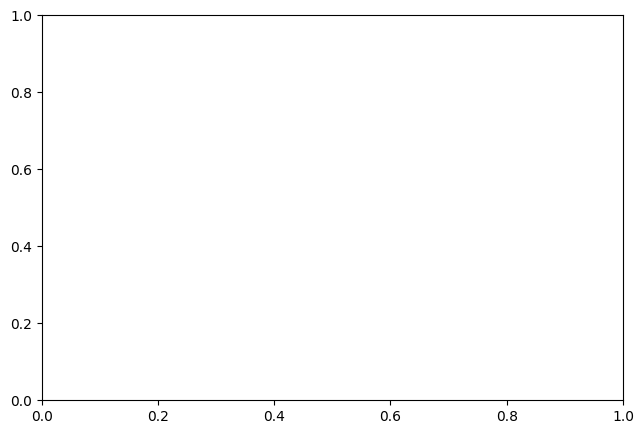

In [57]:
shap.dependence_plot("value__mean_change", shap_values, X_train, interaction_index="value__mean_n_absolute_max__number_of_maxima_7")

TypeError: only integer scalar arrays can be converted to a scalar index

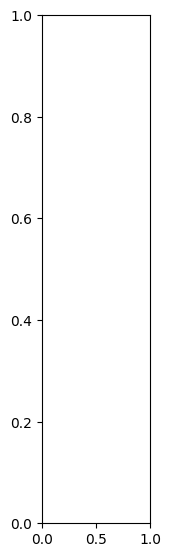

In [54]:
shap.summary_plot(shap_values, features)

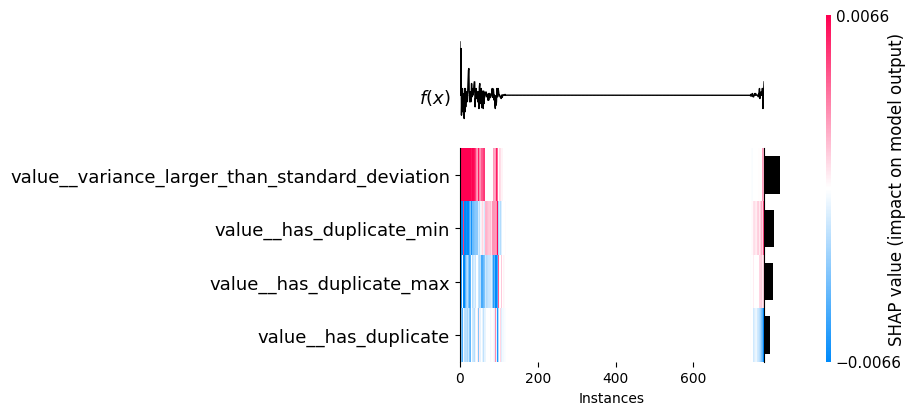

In [91]:
shap.plots.heatmap(shap_values[3])

In [62]:
def explain_with_shap(model, X_train, X_test):
    """
    Uses SHAP values to explain the model predictions.
    
    Args:
    model (RandomForestClassifier): The trained model.
    X_train (DataFrame): Training dataset (used to build the SHAP explainer).
    X_test (DataFrame): Test dataset (to explain the model predictions).
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # Plot summary plot using SHAP values (aggregate view)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    
    # Plot the SHAP values for the first prediction
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

shap_plot = explain_with_shap(model, X_train, pd.DataFrame(new_sequence))
shap_plot

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.